In [1]:
import warnings; warnings.simplefilter('ignore')      # 忽略警告信息；
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
# from scipy.stats import norm
from matplotlib import pyplot as plt
from tqdm import *

## Predict reinvest decisions

In [2]:
df = pd.read_csv('modified_data.csv')
del df['Unnamed: 0']
choose_feature = pd.read_csv('choose_feature.csv')
del choose_feature['Unnamed: 0']

In [3]:
choose_label = df['label']
choose_feature['rounds'] = df['rounds']

In [4]:
df['investor_name'] = df['first_name'].apply(str) + df['last_name'].apply(str) 
compy_name = df['Company name'].unique().tolist()
invstr_name = df['investor_name'].unique().tolist()
ddd = pd.DataFrame()

In [5]:
for compy in tqdm(compy_name):
    for invt in invstr_name:
        dd = df[(df['Company name'] == compy)&(df.investor_name == invt)]
        dd = dd.sort_values(by='rounds')
        try:
            dd['percent_total_1'] = dd['percent_total'].values[0]
            ddd = pd.concat([ddd,dd],axis=0)
#             print(ddd.head(2))
        except:
            continue

100%|██████████████████████████████████████████████████████████████████████████████████| 82/82 [10:10<00:00,  7.44s/it]


In [6]:
data = ddd.copy()

In [7]:
data['percent_total'] = data['percent_total_1']

In [8]:
choose_factor = [i for i in df.columns if i in ['rounds','percent_total','valuation','value_chg',
                                                 'follow_count','industry_2','industry_val',
                                                 'investor_count','founder_count','male_ratio','rate']]

In [10]:
import xgboost as xgb 
from sklearn.model_selection import train_test_split  # Split training set and test set
from sklearn.preprocessing import LabelEncoder   # Labelled classification parameters
le = LabelEncoder()
choose_label = le.fit_transform(choose_label)
X_train,X_test,y_train,y_test = train_test_split(choose_feature, choose_label,test_size=0.3,random_state=1,stratify=choose_label)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test)
# 1.Booster parameters
params = {
    'booster': 'gbtree',
    'objective': 'multi:softmax',
    
    'num_class': 10,               # Number of classes, used in conjunction with multisoftmax    
                                   #'objective': 'multi:softmax'
                                   # Multiple classification issues 'objective':'binary:logistic'
    'gamma': 0.1,                  # The larger the parameter, the more conservative it is, usually 0.1 or 0.2.
    'max_depth': 30,               # Build the depth of the tree, the larger the tree, the easier it is to over-fit.
    'lambda': 1,                   # The parameter of the L1 regularisation term that controls the weight value of the model complexity.
                                   #the larger the parameter, the less likely the model is to be overfitted.
    'subsample': 0.9,              # randomly sampled training samples
    'colsample_bytree': 0.8,       # column sampling during tree generation
    'min_child_weight': 3,
    'silent': 0,                   # If it is set to 1, no run message is output and it is better to set it to 0.
    'eta': 0.003,                  # similar with the learning rate
    'seed': 1000,
    'nthread': 6,                  # cpu threads# specify the validation set
    'eval_metric':'auc'
}
plst = list(params.items())
# evallist = [(dtest, 'eval'), (dtrain, 'train')]   # specify the validation set

In [11]:
# 2.train
num_round = 10
bst = xgb.train(plst, dtrain, num_round)
#bst = xgb.train( plst, dtrain, num_round, evallist )

[01:10:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




In [12]:
data['predict_label'] = bst.predict(xgb.DMatrix(data[choose_factor]))

In [13]:
data.columns

Index(['Company name', 'filing_date', 'total_shares', 'round_shares', 'rounds',
       'first_name', 'last_name', 'number_of_shares', 'percent_total',
       'Deal date', 'Investment amount', 'Incorporation date', 'Current stage',
       'Exit date', 'Exit price', 'investor_count', 'male', 'female',
       'founder_count', 'exit_shares', 'add_shares', 'follow', 'valuation',
       'first_industry', 'value_chg', 'follow_count', 'rate', 'industry_val',
       'male_ratio', 'label', 'industry_1', 'industry_2', 'investor_name',
       'percent_total_1', 'predict_label'],
      dtype='object')

In [14]:
data['paid_in_once'] = data['round_shares']*data['valuation']*data['percent_total']

In [15]:
data_add_paidin = pd.DataFrame()

In [16]:
for compy in tqdm(compy_name):
    for invt in invstr_name:
        dd = data[(data['Company name'] == compy)&(data.investor_name == invt)]
        dd = dd.sort_values(by='rounds')
        dd['paid_in'] = dd['paid_in_once'].cumsum()
        data_add_paidin = pd.concat([data_add_paidin,dd],axis=0)

100%|██████████████████████████████████████████████████████████████████████████████████| 82/82 [45:30<00:00, 33.30s/it]


In [17]:
data_add_paidin.to_csv('data_add_paidin.csv')

## import data_add_paidin.csv

In [18]:
data_add_paidin = pd.read_csv('data_add_paidin.csv')
del data_add_paidin['Unnamed: 0']

In [19]:
data_add_paidin.columns

Index(['Company name', 'filing_date', 'total_shares', 'round_shares', 'rounds',
       'first_name', 'last_name', 'number_of_shares', 'percent_total',
       'Deal date', 'Investment amount', 'Incorporation date', 'Current stage',
       'Exit date', 'Exit price', 'investor_count', 'male', 'female',
       'founder_count', 'exit_shares', 'add_shares', 'follow', 'valuation',
       'first_industry', 'value_chg', 'follow_count', 'rate', 'industry_val',
       'male_ratio', 'label', 'industry_1', 'industry_2', 'investor_name',
       'percent_total_1', 'predict_label', 'paid_in_once', 'paid_in'],
      dtype='object')

## Always Follow-on
### Involve in every funding round until the company Dead/M&A/IPO.

In [20]:
temp = data_add_paidin.drop_duplicates(subset=['Company name','investor_name'], keep='last', inplace=False) 

In [21]:
temp['tvpi'] = temp['percent_total'] * temp['Exit price']/temp['paid_in']

In [22]:
always = pd.merge(data_add_paidin,temp[['Company name','investor_name','tvpi']],on=['Company name','investor_name'],how='outer')

In [40]:
always.to_csv(r'always_tvpi.csv')

In [23]:
always = always.dropna()

In [24]:
always_mean = np.mean(always['tvpi'].values.tolist())
always_median = np.median(always['tvpi'].values.tolist())
print('always_mean =',always_mean)
print('always_median =',always_median)

always_mean = 0.5496734257176457
always_median = 0.0


In [25]:
always['tvpi'].value_counts()

0.000000     1543
9.331895       42
7.260005       15
7.260005       15
0.431035        8
7.260005        6
0.431035        4
12.164524       3
18.663790       3
18.246786       2
32.699423       2
32.699423       1
18.663790       1
Name: tvpi, dtype: int64

<AxesSubplot:xlabel='tvpi', ylabel='Density'>

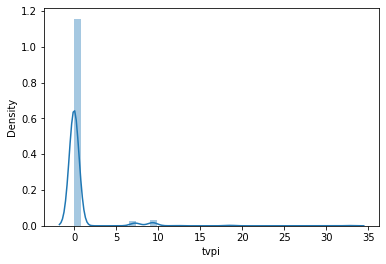

In [26]:
sns.distplot(always['tvpi'])

## Never Follow-on
### Only involve in the first funding round.

In [27]:
never = always.loc[always['rounds']==1]

In [28]:
never['tvpi'] = never['percent_total']*never['Exit price']/never['paid_in_once']

In [29]:
never_mean = np.mean(never['tvpi'].values.tolist())
never_median = np.median(never['tvpi'].values.tolist())
print('never_mean =',never_mean)
print('never_median =',never_median)

never_mean = 0.02972654808523686
never_median = 0.0


In [30]:
never['tvpi'].value_counts()

0.00000    171
1.72414      2
1.72414      1
Name: tvpi, dtype: int64

<AxesSubplot:xlabel='tvpi', ylabel='Density'>

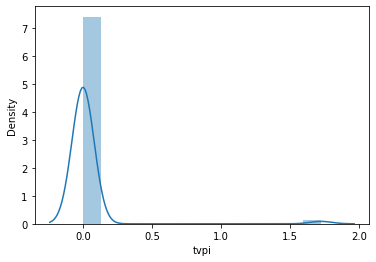

In [31]:
sns.distplot(never['tvpi'])

## Follow-on according to the model predictions
### Involve in subsequent rounds until the prediction output is ‘not follow-on’(label=0)

In [32]:
# always['rounds'].unique().tolist()

In [33]:
# always['predict_label']

In [34]:
predict = always
length_column = predict.shape[0]

for i in tqdm(range(0,length_column)):
    if (predict['Company name'].iloc[i] == predict['Company name'].iloc[i-1])&(predict['investor_name'].iloc[i] == predict['investor_name'].iloc[i-1]):
        predict['predict_label'].iloc[i] = predict['predict_label'].iloc[i]*predict['predict_label'].iloc[i-1]
    else:
        predict['predict_label'].iloc[i] = 1

100%|████████████████████████████████████████████████████████████████████████████| 1645/1645 [00:00<00:00, 1867.15it/s]


In [35]:
# predict.info()

In [36]:
predict['add_shares'] = predict['percent_total'] * predict['round_shares'] * predict['predict_label']
predict['paid_in_each'] = predict['add_shares'] * predict['valuation']

In [37]:
predict['paid_in_add']=''
length_column = predict.shape[0]
for i in tqdm(range(0,length_column)):
    if (predict['Company name'].iloc[i] == predict['Company name'].iloc[i-1])&(predict['investor_name'].iloc[i] == predict['investor_name'].iloc[i-1]):
        predict['number_of_shares'].iloc[i] = predict['number_of_shares'].iloc[i-1] + predict['add_shares'].iloc[i]
        predict['paid_in_add'].iloc[i] = predict['paid_in_add'].iloc[i-1] + predict['paid_in_each'].iloc[i]
    else:
        predict['number_of_shares'].iloc[i] = predict['add_shares'].iloc[i]
        predict['paid_in_add'].iloc[i] = predict['paid_in_each'].iloc[i]    

100%|█████████████████████████████████████████████████████████████████████████████| 1645/1645 [00:01<00:00, 989.18it/s]


In [38]:
predict['tvpi'] = ((predict['number_of_shares'] / predict['total_shares']) * predict['Exit price']) / predict['paid_in_add']

In [39]:
predict_mean = np.mean(predict['tvpi'].values.tolist())
predict_median = np.median(predict['tvpi'].values.tolist())
print('predict_mean =',predict_mean)
print('predict_median =',predict_median)

predict_mean = 0.7083267727455683
predict_median = 0.0
